# Fine-tuning on Pre-trained Model for Cell-State Annotation
In this tutorial, we demonstrate how to fine-tune a pre-trained model on a new dataset for the cell state annotation task. We use the Single Nucleus Nueroblastoma dataset with 2000 highly variable genes.

We summarize the fine-tuning pipeline in the following steps, which can be used as a general recipe for finetuning on Cell-State annotation tasks and beyond: 

     1. Specify hyper-parameter setup for integration task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. Finetune scGPT with task-specific objectives
     
     5. Evaluate fine-tuned scGPT

In [1]:
# %%
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

Global seed set to 0
/home/themandalorian/anaconda3/envs/scGPT/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/themandalorian/anaconda3/envs/scGPT/lib/python3.9/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/themandalorian/ETH/PMLR2025/scGPT/pmlr25/../scgpt/model/model.py:21: U

## Step1: Specify hyper-parameter setup for Cell-State annotation task
Listed below are some hyper-parameter recommendations for the Cell-State task. Note that the CLS objective is on to facilitate Cell-State classification.

In [2]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="ms",
    do_train=True,
    load_model="../save/scGPT_pancancer",
    mask_ratio=0.0,
    epochs=10,
    n_bins=51,
    MVC=False, # Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-4,
    batch_size=32,
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

In [3]:
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT_pancancer_finetune-cell_state-NB-Endothelial_Second",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: keymor (keymor-eth) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


{'seed': 0, 'dataset_name': 'ms', 'do_train': True, 'load_model': '../save/scGPT_pancancer', 'mask_ratio': 0.0, 'epochs': 10, 'n_bins': 51, 'MVC': False, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': False, 'DSBN': False}


In [4]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
max_seq_len = 3001
n_bins = config.n_bins

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = True  # cellstate classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
ECS = config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product"
ecs_threshold = config.ecs_thres
dab_weight = config.dab_weight

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True

In [5]:
# %% validate settings
assert input_style in ["normed_raw", "log1p", "binned"]
assert output_style in ["normed_raw", "log1p", "binned"]
assert input_emb_style in ["category", "continuous", "scaling"]
if input_style == "binned":
    if input_emb_style == "scaling":
        raise ValueError("input_emb_style `scaling` is not supported for binned input.")
elif input_style == "log1p" or input_style == "normed_raw":
    if input_emb_style == "category":
        raise ValueError(
            "input_emb_style `category` is not supported for log1p or normed_raw input."
        )

if input_emb_style == "category":
    mask_value = n_bins + 1
    pad_value = n_bins  # for padding gene expr values
    n_input_bins = n_bins + 2
else:
    mask_value = -1
    pad_value = -2
    n_input_bins = n_bins

if ADV and DAB:
    raise ValueError("ADV and DAB cannot be both True.")
DAB_separate_optim = True if DAB > 1 else False

In [6]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_ms-May15-01-06


## Step 2: Load and pre-process data
We follow the standard scGPT data pre-processing pipelines for the Cell-State annotation task. Note that since now we have two datasets at hand (i.e., reference and query data), the same pre-prpocessing steps need to be applied to both of them.

In [7]:
from scipy import sparse

def get_size(x):
    """Get memory size of an object in bytes."""
    if x is None:
        return 0
    if isinstance(x, np.ndarray):
        return x.nbytes
    if sparse.issparse(x):
        return (x.data.nbytes + x.indptr.nbytes + x.indices.nbytes)
    if hasattr(x, "memory_usage"):
        return x.memory_usage(deep=True).sum()
    if isinstance(x, dict):
        return sum(get_size(v) for v in x.values())
    if isinstance(x, (list, tuple)):
        return sum(get_size(v) for v in x)
    return 0

def print_anndata_memory_report(adata, name="adata"):
    print(f"\nMemory report for {name}:")
    total = 0

    components = {
        "X": adata.X,
        "obs": adata.obs,
        "var": adata.var,
        "uns": adata.uns,
        "obsm": adata.obsm,
        "varm": adata.varm,
        "obsp": adata.obsp,
    }

    for key, obj in components.items():
        size = get_size(obj)
        total += size
        print(f"  {key:<5}: {size / 1e6:.2f} MB")

    if hasattr(adata, "layers"):
        layer_total = 0
        for layer_name, layer_data in adata.layers.items():
            size = get_size(layer_data)
            layer_total += size
            print(f"  Layer '{layer_name}': {size / 1e6:.2f} MB")
        total += layer_total

    print(f"Total estimated memory: {total / 1e6:.2f} MB\n")


In [8]:
#if dataset_name == "ms":   
data_dir = Path("../data/") ## HERE YOUR DATA PATH
adata = sc.read(data_dir /"NBatlas_cnv_endothelial_ref_percluster2000hvg.h5ad")  ## REFERENCE DATASET 1

print(adata)

AnnData object with n_obs × n_vars = 119439 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'Study', 'Assay', 'Platform', 'Sample', 'Patient_No', 'Timepoint', 'INSS_stage', 'MYCN_amplification', 'Gender', 'Risk', 'Cell_condition', 'Cell_type', 'cell', 'n_genes', 'leiden', 'cnv_leiden', 'cnv_score', 'cnv_status'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std', 'chromosome', 'start', 'end', 'gene_id', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cell_type_colors', 'INSS_stage_colors', 'Sample_colors', 'Study_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_pca_harmony', 'X_umap', 'scvi_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities'

In [9]:
adata_ref = sc.read(data_dir /"sn_tumor_cells_NB_hvg.h5ad")  ## REFERENCE DATASET 2
print(adata_ref)

AnnData object with n_obs × n_vars = 205153 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Stage_Code', 'Tissue', 'Risk_Category', 'First_Avail_TP', 'MYCN_Status', 'ALK_Status', 'TP53_Status', 'Response', 'Vital_Status', 'Age_at_IDX_in_months', 'Treatment', 'First_Avail_Time_Point', 'sample_name', 'biospecimen_id', 'percent.mt', 'seurat_clusters', 'sample_label_wo_prefix', 'S.Score', 'G2M.Score', 'Phase', 'malignancy', 'cell_state', 'RNA_snn_res.0.2', 'MES_Score', 'ADRN_Score', 'MES_ADRN_diff', 'Event', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'tissue_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'leiden'
    var: 'gene

In [10]:
adata = adata[adata.obs['Assay'] == 'single-nucleus'].copy()
print(adata)

AnnData object with n_obs × n_vars = 53758 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'Study', 'Assay', 'Platform', 'Sample', 'Patient_No', 'Timepoint', 'INSS_stage', 'MYCN_amplification', 'Gender', 'Risk', 'Cell_condition', 'Cell_type', 'cell', 'n_genes', 'leiden', 'cnv_leiden', 'cnv_score', 'cnv_status'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std', 'chromosome', 'start', 'end', 'gene_id', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cell_type_colors', 'INSS_stage_colors', 'Sample_colors', 'Study_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_pca_harmony', 'X_umap', 'scvi_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities',

In [15]:
print(adata.var['hgnc_symbol'])
print(adata.var['ensembl_gene_id'])
print(adata.var['gene_id'])
print(adata.var['gene_name'])
print(adata.var['gene_biotype'])
print(adata.var['chromosome'])

hgnc_symbol
ISG15              ISG15
TNFRSF4          TNFRSF4
HES5                HES5
AL592464.3    AL592464.3
AL805961.1    AL805961.1
                 ...    
AL132821.1    AL132821.1
U62317.5        U62317.5
AL445470.1    AL445470.1
AC020571.1    AC020571.1
AC078864.2    AC078864.2
Name: hgnc_symbol, Length: 2000, dtype: object
hgnc_symbol
ISG15         ENSG00000187608
TNFRSF4       ENSG00000186827
HES5          ENSG00000197921
AL592464.3                NaN
AL805961.1                NaN
                   ...       
AL132821.1                NaN
U62317.5                  NaN
AL445470.1                NaN
AC020571.1                NaN
AC078864.2                NaN
Name: ensembl_gene_id, Length: 2000, dtype: category
Categories (1157, object): ['ENSG00000004799', 'ENSG00000006128', 'ENSG00000006327', 'ENSG00000007312', ..., 'ENSG00000292197', 'ENSG00000292233', 'ENSG00000293545', 'ENSG00000293547']
hgnc_symbol
ISG15         ENSG00000187608
TNFRSF4       ENSG00000186827
HES5          

In [16]:
adata.X = adata.layers['log1p_norm']
adata_ref.X = adata_ref.layers['log1p_norm']

In [17]:
from mygene import MyGeneInfo

mg = MyGeneInfo()

hgnc_symbols = adata.var['hgnc_symbol'].tolist()
results = mg.querymany(hgnc_symbols, scopes='symbol', fields='ensembl.gene', species='human')

# Create mapping dataframe
map_df = pd.DataFrame(results)
map_df = map_df[map_df['notfound'] != True]  # drop unfound symbols

# Handle nested Ensembl field
def extract_ensembl_id(entry):
    if isinstance(entry, list):
        return entry[0]['gene']
    elif isinstance(entry, dict):
        return entry.get('gene')
    return None

map_df['ensembl_id'] = map_df['ensembl'].apply(extract_ensembl_id)
map_df = map_df[['query', 'ensembl_id']].dropna()
map_df = map_df.drop_duplicates(subset='query')

# Create dictionary for fast lookup
gene_map = map_df.set_index('query')['ensembl_id'].to_dict()

# Map Ensembl IDs to each row using existing hgnc_symbol
adata.var['ensembl_id_mapped'] = adata.var['hgnc_symbol'].map(gene_map)

mask = (
    adata.var['ensembl_gene_id'].notnull() &
    adata.var['ensembl_id_mapped'].notnull()
)

adata = adata[:, mask]

print(adata.var['ensembl_gene_id'])
print(adata.var['ensembl_id_mapped'])

print(adata_ref.var_names)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
213 input query terms found dup hits:	[('RPL12P13', 2), ('PRDX3P2', 2), ('BRI3P1', 2), ('NBPF5P', 2), ('PGBP', 2), ('RPS15AP9', 2), ('ABHD
842 input query terms found no hit:	['AL592464.3', 'AL805961.1', 'Z98886.1', 'AL109936.8', 'AL445686.1', 'AL031432.1', 'AL033528.3', 'AL


hgnc_symbol
ISG15        ENSG00000187608
TNFRSF4      ENSG00000186827
HES5         ENSG00000197921
LINC01646    ENSG00000232596
RBP7         ENSG00000162444
                  ...       
LINC01903    ENSG00000265555
LINC01922    ENSG00000259779
LINC01896    ENSG00000282765
PARAL1       ENSG00000243961
LINC01634    ENSG00000235295
Name: ensembl_gene_id, Length: 1147, dtype: category
Categories (1147, object): ['ENSG00000004799', 'ENSG00000006128', 'ENSG00000006327', 'ENSG00000007312', ..., 'ENSG00000292197', 'ENSG00000292233', 'ENSG00000293545', 'ENSG00000293547']
hgnc_symbol
ISG15        ENSG00000187608
TNFRSF4      ENSG00000186827
HES5         ENSG00000197921
LINC01646    ENSG00000232596
RBP7         ENSG00000162444
                  ...       
LINC01903    ENSG00000265555
LINC01922    ENSG00000259779
LINC01896    ENSG00000282765
PARAL1       ENSG00000243961
LINC01634    ENSG00000235295
Name: ensembl_id_mapped, Length: 1147, dtype: object
Index(['ENSG00000186891', 'ENSG00000235098', 'E

In [18]:
mask = (adata_ref.var_names.notnull())

adata_ref = adata_ref[:, mask]

print(adata_ref)
print(adata)

View of AnnData object with n_obs × n_vars = 205153 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Stage_Code', 'Tissue', 'Risk_Category', 'First_Avail_TP', 'MYCN_Status', 'ALK_Status', 'TP53_Status', 'Response', 'Vital_Status', 'Age_at_IDX_in_months', 'Treatment', 'First_Avail_Time_Point', 'sample_name', 'biospecimen_id', 'percent.mt', 'seurat_clusters', 'sample_label_wo_prefix', 'S.Score', 'G2M.Score', 'Phase', 'malignancy', 'cell_state', 'RNA_snn_res.0.2', 'MES_Score', 'ADRN_Score', 'MES_ADRN_diff', 'Event', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'tissue_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'leiden'
    va

In [19]:
print(adata_ref.var['ensembl_id_version'])

genes_1 = set(adata.var['ensembl_gene_id'].dropna().unique())
genes_2 = set(adata.var['ensembl_id_mapped'].dropna().unique())
genes_3 = set(adata_ref.var_names)

common_genes = genes_1 & genes_2 & genes_3
print(f"Number of common genes: {len(common_genes)}")

print(f"Unique genes in adata.var['ensembl_gene_id']: {len(genes_1)}")
print(f"Unique genes in adata.var['ensembl_id_mapped']: {len(genes_2)}")
print(f"Unique genes in adata_ref.var_names: {len(genes_3)}")

ensembl_id
ENSG00000186891    ENSG00000186891.14
ENSG00000235098     ENSG00000235098.8
ENSG00000179403    ENSG00000179403.12
ENSG00000142611    ENSG00000142611.17
ENSG00000130762    ENSG00000130762.15
                          ...        
ENSG00000198840     ENSG00000198840.2
ENSG00000212907     ENSG00000212907.2
ENSG00000198886     ENSG00000198886.2
ENSG00000198695     ENSG00000198695.2
ENSG00000198727     ENSG00000198727.2
Name: ensembl_id_version, Length: 2000, dtype: object
Number of common genes: 292
Unique genes in adata.var['ensembl_gene_id']: 1147
Unique genes in adata.var['ensembl_id_mapped']: 1147
Unique genes in adata_ref.var_names: 2000


In [20]:
# Create a boolean mask where mapped Ensembl ID is in common_genes
adata_ref = adata_ref[:, list(common_genes)]
adata = adata[:, adata.var['ensembl_gene_id'].isin(common_genes)]

print(adata_ref)
print(adata)

View of AnnData object with n_obs × n_vars = 205153 × 292
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Stage_Code', 'Tissue', 'Risk_Category', 'First_Avail_TP', 'MYCN_Status', 'ALK_Status', 'TP53_Status', 'Response', 'Vital_Status', 'Age_at_IDX_in_months', 'Treatment', 'First_Avail_Time_Point', 'sample_name', 'biospecimen_id', 'percent.mt', 'seurat_clusters', 'sample_label_wo_prefix', 'S.Score', 'G2M.Score', 'Phase', 'malignancy', 'cell_state', 'RNA_snn_res.0.2', 'MES_Score', 'ADRN_Score', 'MES_ADRN_diff', 'Event', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'tissue_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'leiden'
    var

In [22]:
adata.var_names = adata.var['ensembl_gene_id']
adata.var_names_make_unique()  # ensures no duplicates


print(adata_ref.var_names)
print(adata.var_names)

print(adata_ref)
print(adata)

Index(['ENSG00000173110', 'ENSG00000171564', 'ENSG00000164104',
       'ENSG00000011465', 'ENSG00000172236', 'ENSG00000254709',
       'ENSG00000087086', 'ENSG00000111341', 'ENSG00000259803',
       'ENSG00000148826',
       ...
       'ENSG00000109205', 'ENSG00000135346', 'ENSG00000164434',
       'ENSG00000130208', 'ENSG00000071991', 'ENSG00000134240',
       'ENSG00000187193', 'ENSG00000168843', 'ENSG00000147256',
       'ENSG00000168685'],
      dtype='object', name='ensembl_id', length=292)
CategoricalIndex(['ENSG00000173372', 'ENSG00000159189', 'ENSG00000173369',
                  'ENSG00000169442', 'ENSG00000126709', 'ENSG00000187513',
                  'ENSG00000142694', 'ENSG00000184292', 'ENSG00000187140',
                  'ENSG00000162595',
                  ...
                  'ENSG00000179142', 'ENSG00000110244', 'ENSG00000136352',
                  'ENSG00000211941', 'ENSG00000166589', 'ENSG00000185231',
                  'ENSG00000223350', 'ENSG00000211658', 'ENSG0000

In [23]:
# STEP 1 — Label adata (query) cells as 'Unknown'
adata.obs['cell_state'] = 'Unknown'

# STEP 2 — Concatenate datasets
adata_combined = adata_ref.concatenate(
    adata,
    batch_key="dataset",  # will be 'ref' and 'query'
    batch_categories=["ref", "query"],
    index_unique=None
)

# STEP 3 — Setup SCVI for modeling
scvi.model.SCVI.setup_anndata(
    adata_combined,
    layer="log1p_norm",      # use normalized data
    labels_key="cell_state", # what we want to predict
    batch_key="dataset"      # account for dataset origin
)

# STEP 4 — Train base SCVI model
scvi_model = scvi.model.SCVI(adata_combined)
scvi_model.train()

# STEP 5 — Create SCANVI model (semi-supervised)
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    unlabeled_category="Unknown"
)
scanvi_model.train()

# STEP 6 — Predict cell states for all cells
all_predictions = scanvi_model.predict(adata_combined)
adata.obs['predicted_cell_state'] = all_predictions[adata_ref.n_obs:]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 31/31: 100%|██████████████████████████| 31/31 [06:22<00:00, 12.52s/it, loss=32.3, v_num=1]

`Trainer.fit` stopped: `max_epochs=31` reached.


Epoch 31/31: 100%|██████████████████████████| 31/31 [06:22<00:00, 12.33s/it, loss=32.3, v_num=1]
INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████████████████████| 10/10 [04:07<00:00, 24.55s/it, loss=92.5, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████████████████████| 10/10 [04:07<00:00, 24.74s/it, loss=92.5, v_num=1]


TypeError: predict() got an unexpected keyword argument 'return_proba'

In [24]:
# STEP 7 — Optional: prediction confidence (probability of max class)
probs = scanvi_model.predict(adata_combined, soft=True)
# Extract confidence as the max probability for each cell
adata.obs['prediction_confidence'] = probs.max(axis=1)[adata_ref.n_obs:]

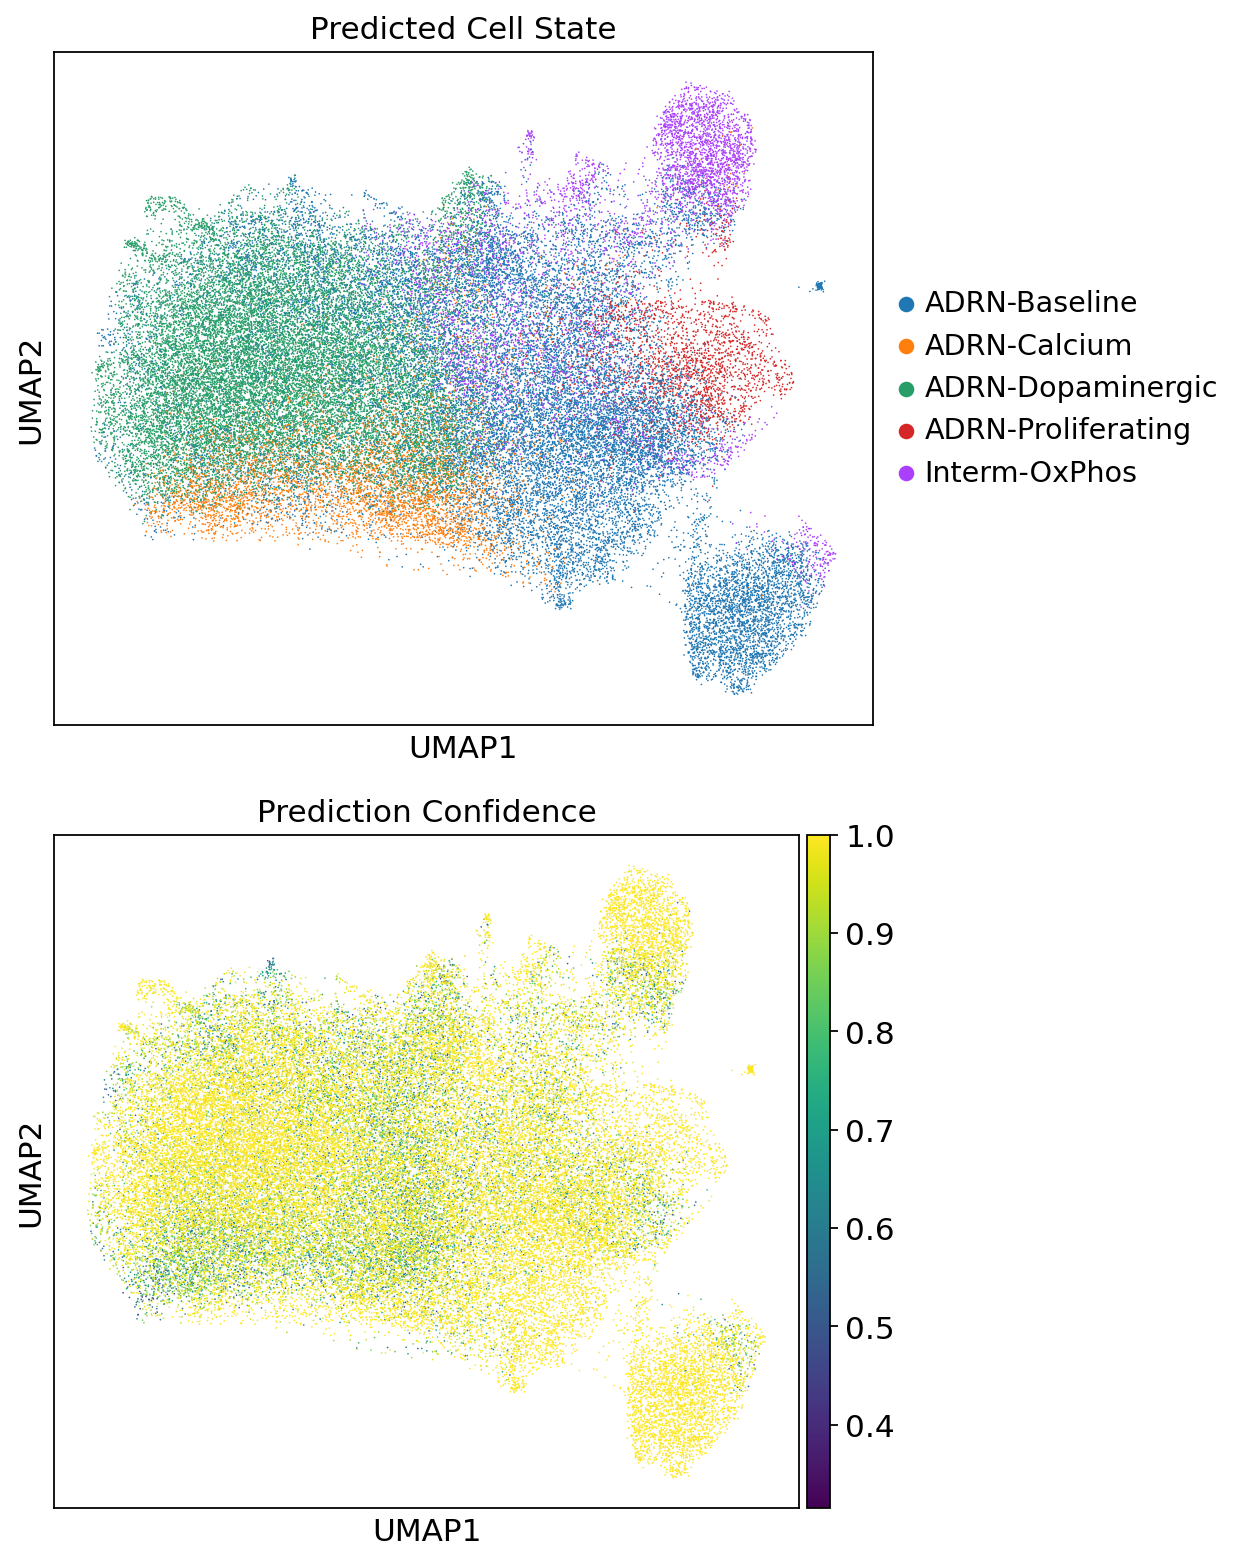

In [27]:
# Get SCANVI latent space
adata_combined.obsm['X_scanvi'] = scanvi_model.get_latent_representation(adata_combined)

# Split the latent space for adata (query only)
adata.obsm['X_scanvi'] = adata_combined.obsm['X_scanvi'][adata_ref.n_obs:]

# Use the latent representation for UMAP
sc.pp.neighbors(adata, use_rep='X_scanvi')
sc.tl.umap(adata)

# Plot UMAPs vertically
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

sc.pl.umap(
    adata, 
    color='predicted_cell_state', 
    ax=axes[0], 
    show=False, 
    title='Predicted Cell State'
)

sc.pl.umap(
    adata, 
    color='prediction_confidence', 
    ax=axes[1], 
    show=False, 
    title='Prediction Confidence'
)

plt.tight_layout()
plt.show()

In [32]:
print(adata.obs['predicted_cell_state'])
print(adata.obs['Cell_type'])

cell
AAACCTGAGCAATATG_Jansky2021_NB03                                   ADRN-Baseline
AAACCTGAGCGCTTAT_Jansky2021_NB03                                   ADRN-Baseline
AAACCTGAGGCACATG_Jansky2021_NB03                              ADRN-Proliferating
AAACCTGAGTGGCACA_Jansky2021_NB03                              ADRN-Proliferating
AAACCTGAGTTCGCAT_Jansky2021_NB03                               ADRN-Dopaminergic
                                                                     ...        
TTGTAGGCAGCCAGAA-Slyper2020_nucleus_HTAPP-656-SMP-3481_TST         Interm-OxPhos
TTTACTGTCGGTTAAC-Slyper2020_nucleus_HTAPP-656-SMP-3481_TST         Interm-OxPhos
TTTATGCAGTGATCGG-Slyper2020_nucleus_HTAPP-656-SMP-3481_TST         Interm-OxPhos
TTTATGCTCTCTGTCG-Slyper2020_nucleus_HTAPP-656-SMP-3481_TST         Interm-OxPhos
TTTGCGCAGATCACGG-Slyper2020_nucleus_HTAPP-656-SMP-3481_TST         ADRN-Baseline
Name: predicted_cell_state, Length: 53758, dtype: category
Categories (5, object): ['ADRN-Baseline', 'AD

In [33]:
# Save updated AnnData object
adata.write("NBatlas_cnv_endothelial_query_with_predicted_cell_states.h5ad")